In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
PATH = '/content/gdrive/MyDrive/CIS520_models/AE_CIFAR10.pt'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import math


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5, 0.5,0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
cuda = torch.device('cuda')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder,self).__init__()
        self.encoder = nn.Sequential(
                nn.Conv2d(3,12,4,stride=2,padding=1),
                nn.ReLU(),
                nn.Conv2d(12,24,4,stride=2,padding=1),
                nn.ReLU(),
                nn.Conv2d(24,48,4,stride=2,padding=1),
                nn.ReLU()
            )
        self.visualize = nn.Linear(48*4*4,2) #To visualize 2D loadings
        self.decoder = nn.Sequential(
                nn.ConvTranspose2d(48,24,4,stride=2,padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(24,12,4,stride=2,padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(12,3,4,stride=2,padding=1),
                nn.Tanh()
            )

    def forward(self,img):
        encoded = self.encoder(img)
        decoded = self.decoder(encoded)
        return encoded,decoded


In [ ]:
#Train loop
epochs = 100
model = autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [ ]:
trainloss = []
valLoss = []
for epoch in range(epochs):
    runloss = 0.0
    for idx,(img,_) in enumerate(trainloader):
        img = img.cuda()
        encoded,outputs = model.forward(img)
        loss = criterion(outputs,img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        runloss += loss.item()
    runvalLoss = 0.0 
    for vIdx,(vImg,_) in enumerate(testloader):
        vImg = vImg.cuda()
        vEncoded,vOutputs = model.forward(vImg)
        vLoss = criterion(vOutputs,vImg)
        runvalLoss += vLoss.item()
    if((epoch+1)%10 ==0):
        print('Epoch: [{}/{}],trainBatchLoss: {:4f},valLoss: {:.4f}'.format(epoch+1,epochs,runloss/len(trainloader),runvalLoss/len(testloader)))
    trainloss.append(runloss/len(trainloader))
    valLoss.append(runvalLoss/len(testloader))

Epoch: [10/100],trainBatchLoss: 0.011553,valLoss: 0.0100
Epoch: [20/100],trainBatchLoss: 0.010479,valLoss: 0.0094
Epoch: [30/100],trainBatchLoss: 0.009947,valLoss: 0.0094
Epoch: [40/100],trainBatchLoss: 0.009616,valLoss: 0.0090
Epoch: [50/100],trainBatchLoss: 0.009593,valLoss: 0.0098
Epoch: [60/100],trainBatchLoss: 0.009769,valLoss: 0.0088
Epoch: [70/100],trainBatchLoss: 0.009507,valLoss: 0.0092
Epoch: [80/100],trainBatchLoss: 0.009554,valLoss: 0.0084
Epoch: [90/100],trainBatchLoss: 0.009604,valLoss: 0.0091
Epoch: [100/100],trainBatchLoss: 0.009553,valLoss: 0.0090


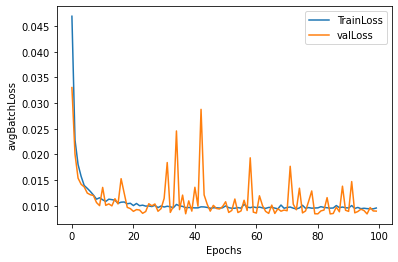

In [ ]:
import matplotlib.pyplot as plt
plt.plot(trainloss,label='TrainLoss')
plt.plot(valLoss,label='valLoss')
plt.xlabel('Epochs')
plt.ylabel('avgBatchLoss')
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), PATH)

In [ ]:
def plot_img_recons(idx,trainset,model):
    img = trainset[idx][0]
    
    encoded,decoded = model.forward(img.view(1,3,32,32).cuda())
    decoded = decoded.squeeze()
    red_decoded = decoded[0].detach().cpu().numpy()
    blue_decoded = decoded[1].detach().cpu().numpy()
    green_decoded = decoded[2].detach().cpu().numpy()
    recon_img = np.stack((red_decoded,blue_decoded,green_decoded),axis=2)
    
    noisy_encoded = encoded.detach().cpu() +np.random.uniform(0,0.5,encoded.shape)
    noisy_decoded = model.decoder(noisy_encoded.type(torch.float).cuda())
    noisy_decoded = noisy_decoded.squeeze()
    noisy_red_decoded = noisy_decoded[0].detach().cpu().numpy()
    noisy_blue_decoded = noisy_decoded[1].detach().cpu().numpy()
    noisy_green_decoded = noisy_decoded[2].detach().cpu().numpy()
    perturbed_img = np.stack((noisy_red_decoded,noisy_blue_decoded,noisy_green_decoded),axis=2)


    f = plt.figure(figsize=(15,5))
    ax1 = f.add_subplot(131)
    ax2 = f.add_subplot(132)
    ax3 = f.add_subplot(133)
    ax1.imshow(trainset.data[idx]/255)
    ax2.imshow(recon_img*0.5 + 0.5)
    ax3.imshow(perturbed_img*0.5 + 0.5)
    print(classes[trainset.targets[idx]])

horse


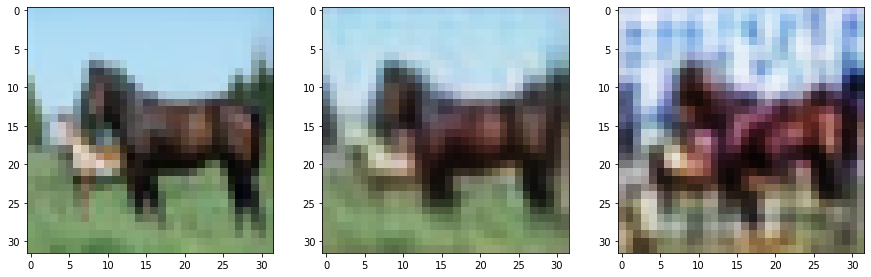

In [ ]:
plot_img_recons(12,trainset,model.cuda())

In [ ]:
model = autoencoder()
#model.load_state_dict(torch.load('AE_CIFAR10.pt'))
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

**ALEXNET INFEERENCE**

In [ ]:
PATHDense = '/content/gdrive/MyDrive/CIS520_models/model_best.pth.tar'

In [ ]:

__all__ = ['alexnet']

class AlexNet(nn.Module):

    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def alexnet(**kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    """
    model = AlexNet(**kwargs)
    return model

In [ ]:
alexModel = AlexNet()
# original saved file with DataParallel
checkpoint = torch.load(PATHDense)
state_dict = checkpoint['state_dict']
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k=="classifier.weight" or k=="classifier.bias":
      name = k
    else:
      name = k[:8]+k[15:] # remove `module.`
    new_state_dict[name] = v
# load params
alexModel.load_state_dict(new_state_dict)

<All keys matched successfully>

In [ ]:
def show_img(idx,trainset):
    img = trainset[idx][0]
    plt.imshow(trainset.data[idx]/255)
def show_pimg(noisy_decoded):
    noisy_red_decoded = noisy_decoded[0].detach().cpu().numpy()
    noisy_blue_decoded = noisy_decoded[1].detach().cpu().numpy()
    noisy_green_decoded = noisy_decoded[2].detach().cpu().numpy()
    perturbed_img = np.stack((noisy_red_decoded,noisy_blue_decoded,noisy_green_decoded),axis=2)
    plt.imshow(perturbed_img)

In [ ]:
def report_pdist(alexmodel,trainset,idx):
  img = trainset[idx][0]
  print(trainset[idx][1])
  linear = alexmodel(img.view(1,3,32,32))
  classification = torch.argmax(linear)
  softmx = nn.Softmax()
  pdist = softmx(linear)
  confidence = pdist[0][trainset[idx][1]]
  return classification, confidence,pdist 

In [ ]:
idx = np.random.randint(0,50000)
a,b,c = report_pdist(alexModel,trainset,idx)

4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


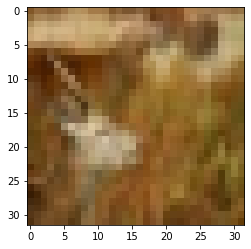

In [ ]:
show_img(idx,trainset)

In [ ]:
print(c[0][trainset[idx][1]])
print(c)

tensor(0.9014, grad_fn=<SelectBackward0>)
tensor([[6.1385e-04, 1.8127e-05, 8.7329e-02, 4.2055e-03, 9.0141e-01, 3.0347e-03,
         2.5351e-03, 6.5337e-04, 1.6306e-04, 3.5350e-05]],
       grad_fn=<SoftmaxBackward0>)


In [ ]:
def report_pdist(alexmodel,img,label):
#   img = trainset[idx][0]
#   print(trainset[idx][1])
  linear = alexmodel(img.view((1,3,32,32)))
  classification = torch.argmax(linear)
  softmx = nn.Softmax()
  pdist = softmx(linear)
  confidence = pdist[0][label]
  return classification, confidence,pdist 

In [ ]:
def random_perturbation(idx,trainset,model,mean=False,stochastic=False):
    img = trainset[idx][0]
    encoded,decoded = model.forward(img.view(1,3,32,32).cuda())
    noisy_encoded = encoded.detach().cpu() +np.random.uniform(0,0.05,encoded.shape)
    noisy_decoded = model.decoder(noisy_encoded.type(torch.float).cuda())
    noisy_decoded = noisy_decoded.squeeze()
    noisy_red_decoded = noisy_decoded[0].detach().cpu().numpy()
    noisy_blue_decoded = noisy_decoded[1].detach().cpu().numpy()
    noisy_green_decoded = noisy_decoded[2].detach().cpu().numpy()
    perturbed_img = np.stack((noisy_red_decoded,noisy_blue_decoded,noisy_green_decoded),axis=2)
    return perturbed_img,trainset[idx][1]


In [ ]:
idx =np.random.randint(0,50000)
pimg,label = random_perturbation(idx,trainset,model)
pimg = torch.from_numpy(pimg)
cl,conf,pdist = report_pdist(alexModel,pimg,label)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


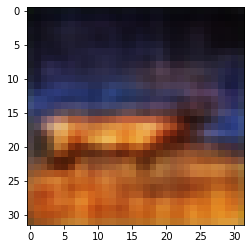

In [ ]:
plt.imshow(pimg*0.5+0.5)

In [ ]:
print(conf,label)
print(pdist)

tensor(0.7316, grad_fn=<SelectBackward0>) 4
tensor([[0.0501, 0.0008, 0.0498, 0.0544, 0.7316, 0.0046, 0.0266, 0.0023, 0.0708,
         0.0089]], grad_fn=<SoftmaxBackward0>)



**STOCHASTIC MOVEMENT**

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,shuffle=True)

In [ ]:
array = next(iter(trainloader))[0].numpy()

In [ ]:
img_data = []
label_data = []
count = 0
for img,label in trainloader:
  #print(img,label)
  in_img = img.numpy()
  img_data.append(img)
  in_label = label.numpy()
  label_data.append(in_label)
  #print(in_img.shape)
  #print(in_label)
  count += 1
  if count == 10000:
    break

# img_data = np.array(img_data)  
# label_data = np.array(label_data)  

In [ ]:
score_arr = []

for images in img_data:
  encode, decode = model.forward(images)
  score_arr.append(encode.detach().numpy())

In [ ]:
score_arr = np.array(score_arr)
print(np.array(score_arr).shape)

(10000, 1, 48, 4, 4)


In [ ]:
from copy import deepcopy
from matplotlib import pyplot as plt

truck
cat
(1, 48, 4, 4)


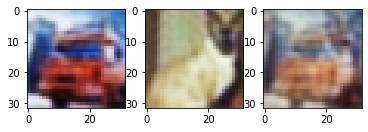

In [ ]:
index_1 = 80
index_2 = 500
score_1 = deepcopy(score_arr[index_1])
score_2 = deepcopy(score_arr[index_2])
print(classes[label_data[index_1][0]])
print(classes[label_data[index_2][0]])
new_score_1 = score_1 + (score_2-score_1)*0.5
print(new_score_1.shape)
tensor_new_score = torch.from_numpy(new_score_1)
decode_img_3(score_1, score_2, new_score_1)

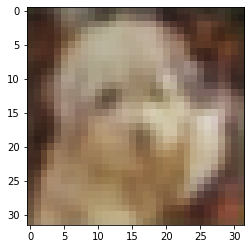

In [ ]:
new_image = model.decoder(tensor_new_score)
new_image = new_image.squeeze()
red_decoded = new_image[0].detach().cpu().numpy()
blue_decoded = new_image[1].detach().cpu().numpy()
green_decoded = new_image[2].detach().cpu().numpy()
recon_img = np.stack((red_decoded,blue_decoded,green_decoded),axis=2)
recon_img = recon_img*0.5+0.5
plt.imshow(recon_img)

In [ ]:
class_of_int = 1
print("class")
print(classes[class_of_int])
score_arr_int = deepcopy(score_arr)
print(score_arr_int.shape)
labels = deepcopy(label_data)
labels = np.reshape(labels, len(labels))
print(labels.shape)
arr_of_int = score_arr_int[np.where(labels==class_of_int)]
print(arr_of_int.shape)


class
car
(10000, 1, 48, 4, 4)
(10000,)
(1001, 1, 48, 4, 4)


In [ ]:
avg = 0.0
for blabla in range(arr_of_int.shape[0]):
  avg = arr_of_int[blabla] + avg

avg = avg/arr_of_int.shape[0]

print(avg.shape)
avg_tensor = torch.from_numpy(avg)


(1, 48, 4, 4)


In [ ]:
def decode_img(nmpy_arr_of_score):
  tensor_from_arr = torch.from_numpy(nmpy_arr_of_score)
  avg_image = model.decoder(tensor_from_arr)
  avg_image = avg_image.squeeze()
  red_avg = avg_image[0].detach().cpu().numpy()
  blue_avg = avg_image[1].detach().cpu().numpy()
  green_avg = avg_image[2].detach().cpu().numpy()
  recon_avg = np.stack((red_avg,blue_avg,green_avg),axis=2)
  recon_avg = recon_avg*0.5+0.5
  plt.imshow(recon_avg)

In [ ]:
def decode_img_3(nmpy_arr_of_score1, nmpy_arr_of_score2, nmpy_arr_of_score3):
  ar = [nmpy_arr_of_score1, nmpy_arr_of_score2, nmpy_arr_of_score3]
  
  for idx, img in enumerate(ar):
    tensor_from_arr = torch.from_numpy(img)
    avg_image = model.decoder(tensor_from_arr)
    avg_image = avg_image.squeeze()
    red_avg = avg_image[0].detach().cpu().numpy()
    blue_avg = avg_image[1].detach().cpu().numpy()
    green_avg = avg_image[2].detach().cpu().numpy()
    recon_avg = np.stack((red_avg,blue_avg,green_avg),axis=2)
    recon_avg = recon_avg*0.5+0.5
    plt.subplot(1,3,idx+1)
    plt.imshow(recon_avg)

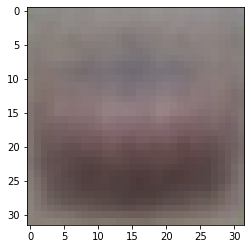

In [ ]:
# avg_image = model.decoder(avg_tensor)
# avg_image = avg_image.squeeze()
# red_avg = avg_image[0].detach().cpu().numpy()
# blue_avg = avg_image[1].detach().cpu().numpy()
# green_avg = avg_image[2].detach().cpu().numpy()
# recon_avg = np.stack((red_avg,blue_avg,green_avg),axis=2)
# recon_avg = recon_avg*0.5+0.5
# plt.imshow(recon_avg)

decode_img(avg)

In [ ]:
#MOVING TOWARDS THE CLUSTER_CENTRE
score_to_move = deepcopy(avg)
arr_of_class = deepcopy(arr_of_int)
score_original = arr_of_class[0]

moved_score = score_original + (score_to_move-score_original)*0.8




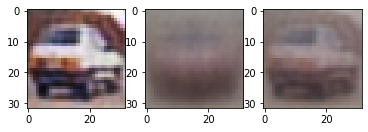

In [ ]:
decode_img_3(score_original, score_to_move, moved_score)

original_image


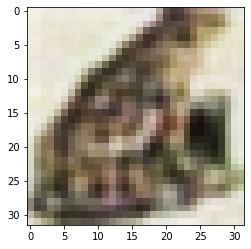

In [ ]:

print("original_image")
decode_img(score_original)

cluster_centre_image


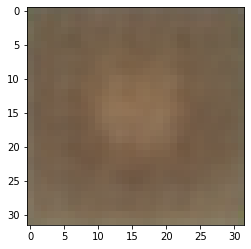

In [ ]:
print("cluster_centre_image")
decode_img(score_to_move)

moved_image


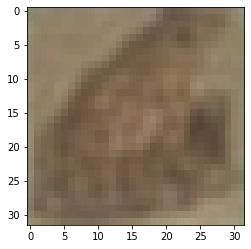

In [ ]:
print("moved_image")
decode_img(moved_score)